In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import util
import heapq

In [ ]:
def edge_detection(image):
    dilated = cv2.dilate(image, None, iterations=1)
    eroded = cv2.erode(image, None, iterations=1)
    edges = dilated - eroded
    return edges

def hole_filling(image):
    filled = cv2.dilate(image, None, iterations=1)
    return filled

def edge_detection(image, method):
    if method == 'log':
        blurred = cv2.GaussianBlur(image, (3, 3), 0)
        edges = cv2.Laplacian(blurred, cv2.CV_64F)
    elif method == 'sobel':
        edges = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=3)
    else:
        raise ValueError('Invalid edge detection method.')
    edges = np.absolute(edges)
    edges = np.uint8(edges)

    return edges

In [ ]:
grayscale_image1 = cv2.imread('grayscale1.jpeg', 0)
grayscale_edges1 = edge_detection(grayscale_image1)
grayscale_filled1 = hole_filling(grayscale_image1)

In [ ]:
grayscale_image2 = cv2.imread('grayscale2.png', 0)
grayscale_edges2 = edge_detection(grayscale_image2)
grayscale_filled2 = hole_filling(grayscale_image2)

In [ ]:
binary_image1 = cv2.imread('binary1.png', 0)
binary_edges1 = edge_detection(binary_image1)
binary_filled1 = hole_filling(binary_image1)

In [ ]:
binary_image2 = cv2.imread('binary2.png', 0)
binary_edges2 = edge_detection(binary_image2)
binary_filled2 = hole_filling(binary_image2)

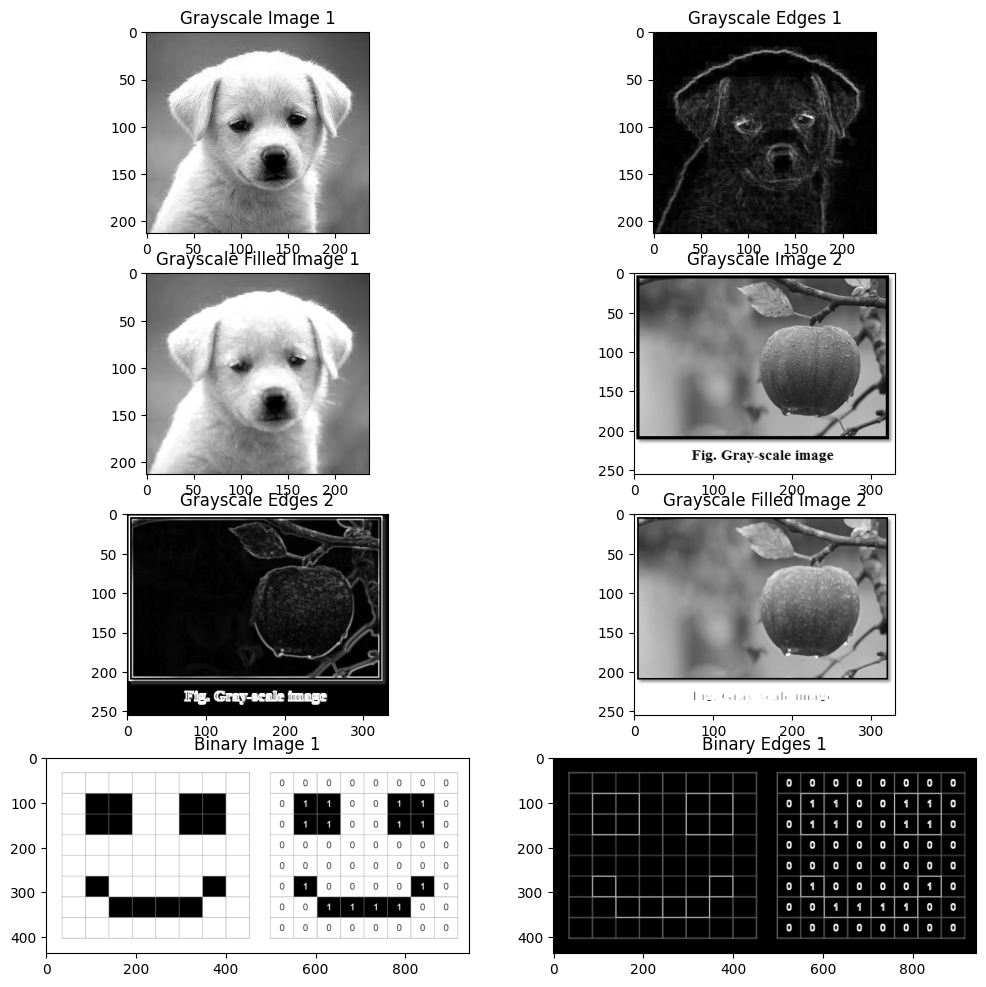

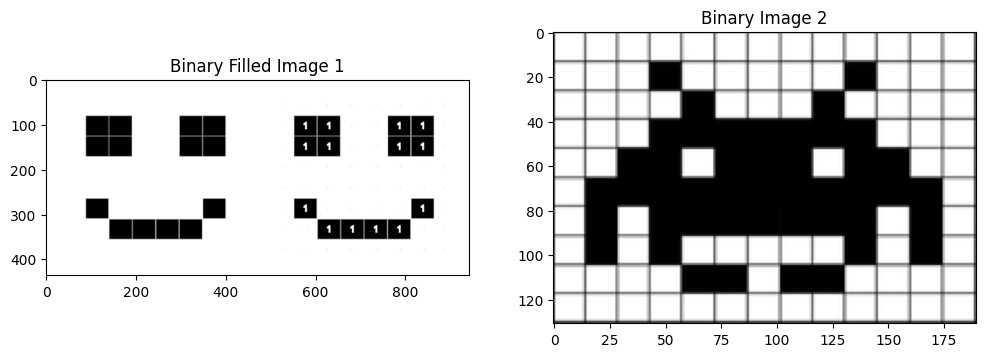

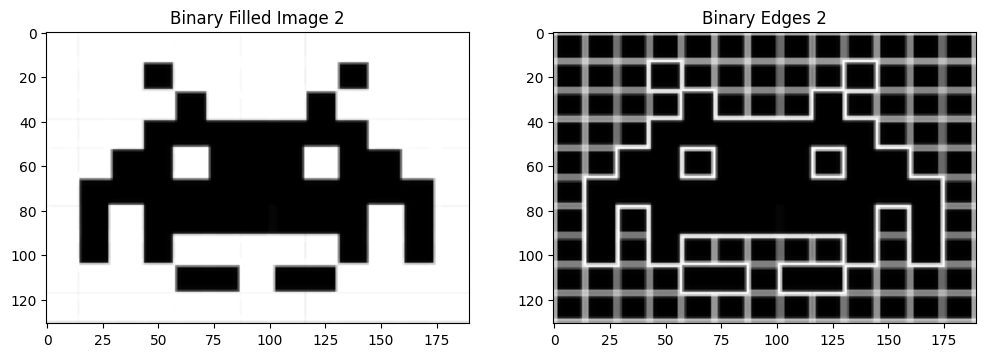

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(421)
plt.imshow(grayscale_image1, cmap='gray')
plt.title('Grayscale Image 1')

plt.subplot(422)
plt.imshow(grayscale_edges1, cmap='gray')
plt.title('Grayscale Edges 1')

plt.subplot(423)
plt.imshow(grayscale_filled1, cmap='gray')
plt.title('Grayscale Filled Image 1')

plt.subplot(424)
plt.imshow(grayscale_image2, cmap='gray')
plt.title('Grayscale Image 2')

plt.subplot(425)
plt.imshow(grayscale_edges2, cmap='gray')
plt.title('Grayscale Edges 2')

plt.subplot(426)
plt.imshow(grayscale_filled2, cmap='gray')
plt.title('Grayscale Filled Image 2')

plt.subplot(427)
plt.imshow(binary_image1, cmap='gray')
plt.title('Binary Image 1')

plt.subplot(428)
plt.imshow(binary_edges1, cmap='gray')
plt.title('Binary Edges 1')

plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.imshow(binary_filled1, cmap='gray')
plt.title('Binary Filled Image 1')

plt.subplot(122)
plt.imshow(binary_image2, cmap='gray')
plt.title('Binary Image 2')

plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.imshow(binary_filled2, cmap='gray')
plt.title('Binary Filled Image 2')

plt.subplot(122)
plt.imshow(binary_edges2, cmap='gray')
plt.title('Binary Edges 2')

plt.show()

In [ ]:
lena_image = cv2.imread('lena.tif', 0)
lena_log_edges = edge_detection(lena_image, 'log')
lena_sobel_edges = edge_detection(lena_image, 'sobel')

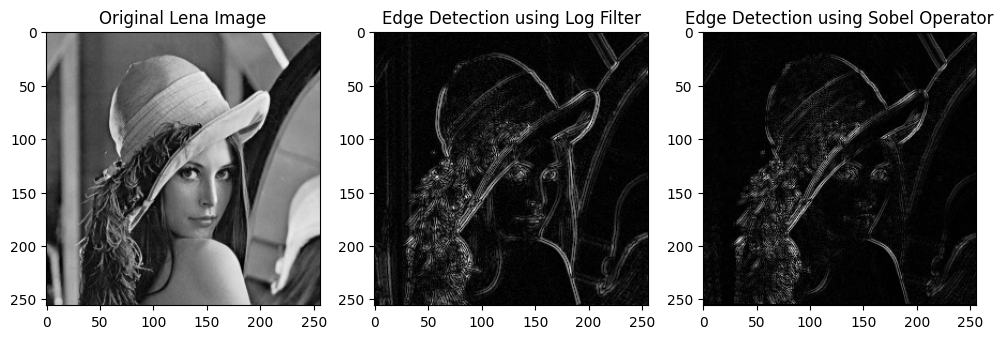

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(lena_image, cmap='gray')
plt.title('Original Lena Image')

plt.subplot(132)
plt.imshow(lena_log_edges, cmap='gray')
plt.title('Edge Detection using Log Filter')

plt.subplot(133)
plt.imshow(lena_sobel_edges, cmap='gray')
plt.title('Edge Detection using Sobel Operator')

plt.show()

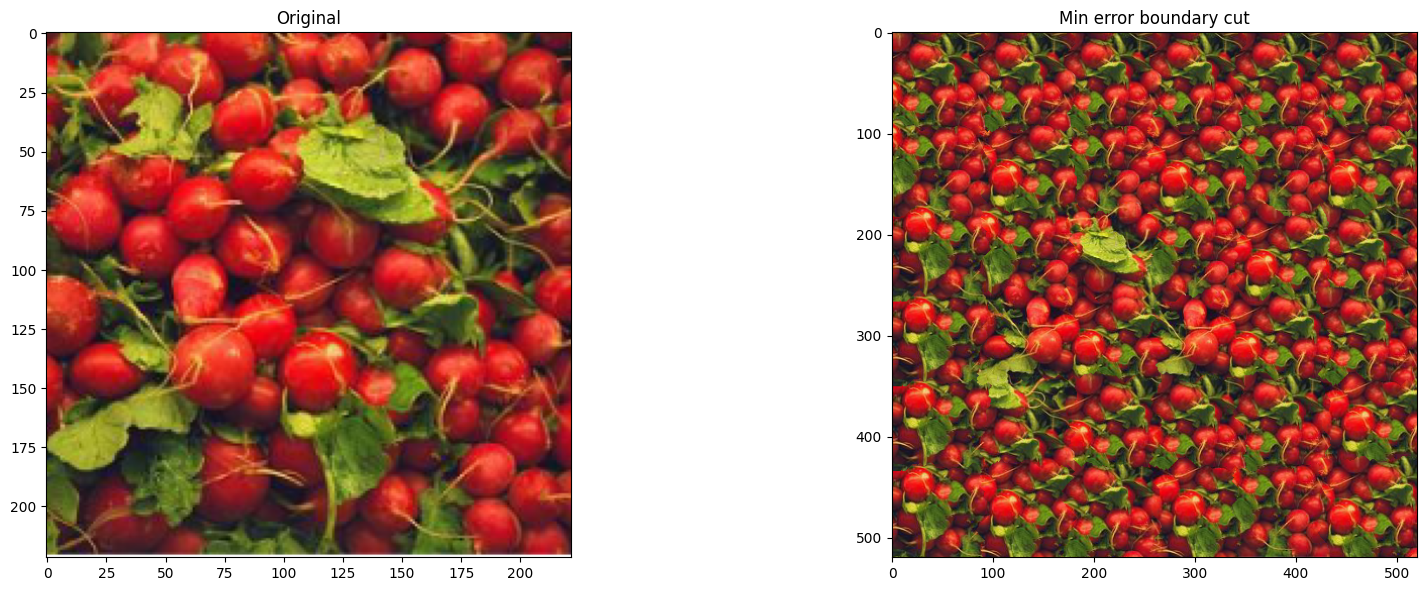

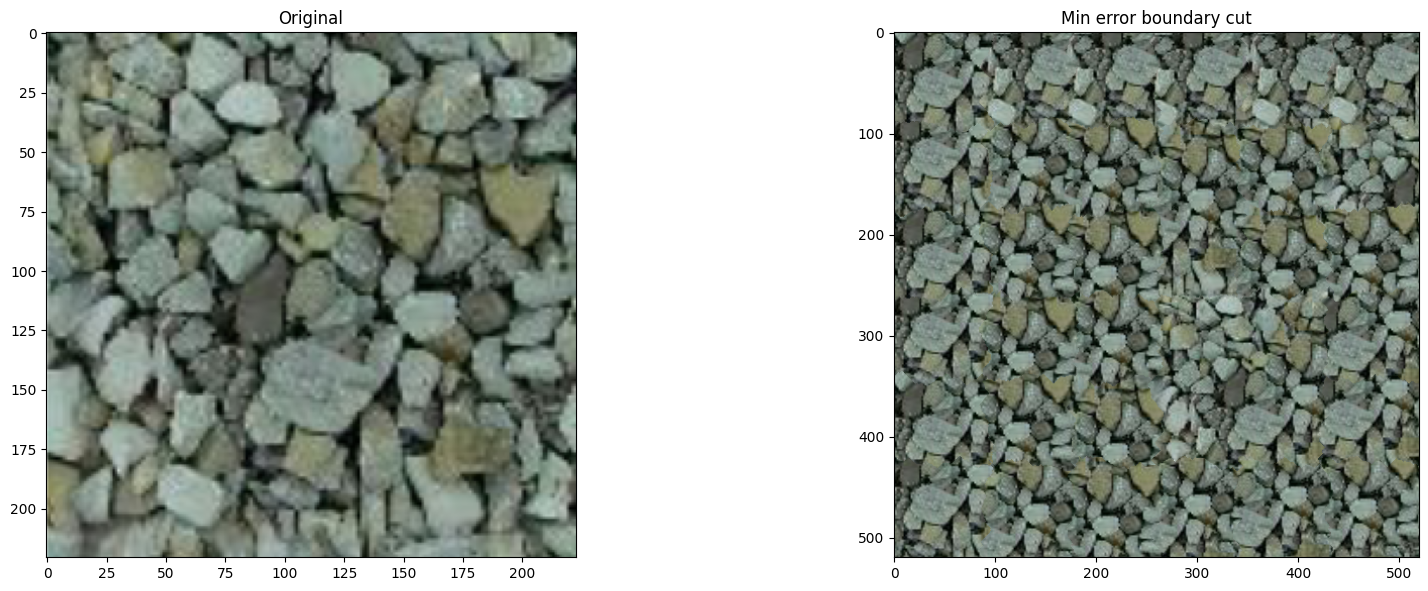

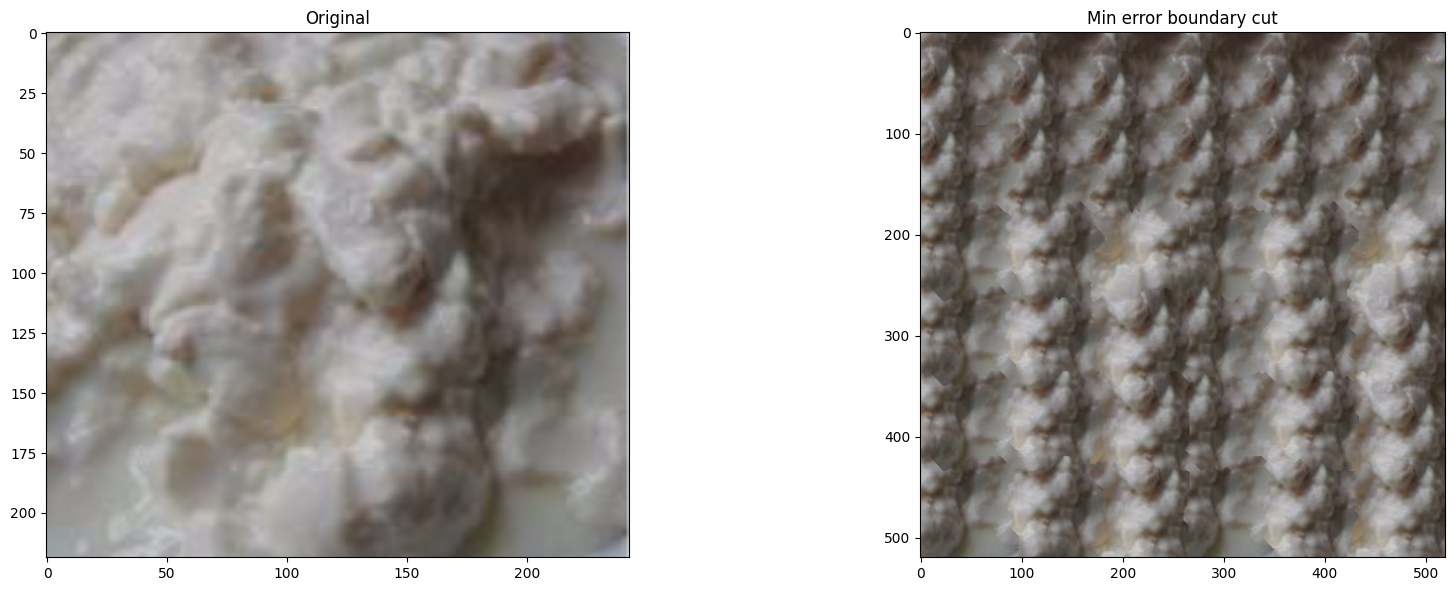

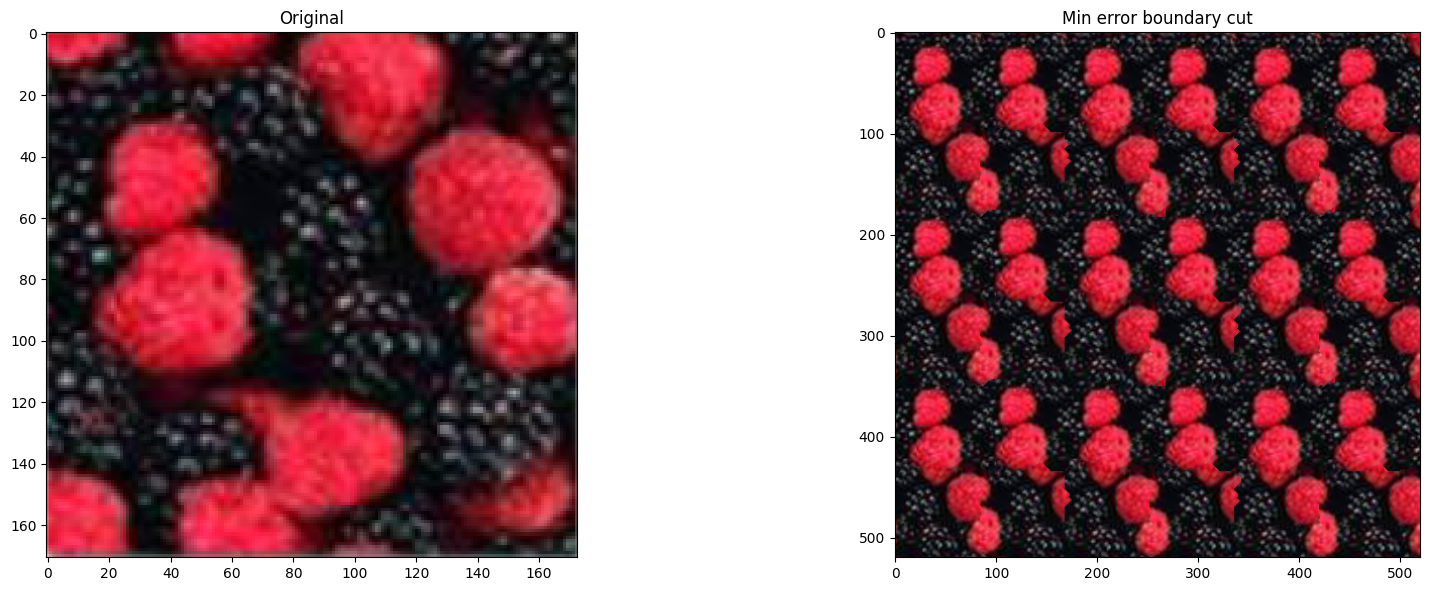

In [ ]:
textures = [plt.imread(f'im{i+1}.png') for i in range(4)]

def calculate_patch_error(patch, length, overlap, result, y, x):
    left = patch[:, :overlap] - result[y:y+length, x:x+overlap]
    up = patch[:overlap, :] - result[y:y+overlap, x:x+length]
    corner = patch[:overlap, :overlap] - result[y:y+overlap, x:x+overlap]

    error = np.sum(left**2) + np.sum(up**2) - np.sum(corner**2)
    return error

def find_best_patch(texture, length, overlap, result, y, x):
    height, width, _ = texture.shape
    errors = np.zeros((height - length, width - length))

    for i in range(height - length):
        for j in range(width - length):
            patch = texture[i:i+length, j:j+length]
            error = calculate_patch_error(patch, length, overlap, result, y, x)
            errors[i, j] = error

    min_index = np.unravel_index(np.argmin(errors), errors.shape)
    i, j = min_index
    return texture[i:i+length, j:j+length]

def find_min_cut_path(errors):
    pq = [(error, [i]) for i, error in enumerate(errors[0])]
    heapq.heapify(pq)

    height, width = errors.shape
    seen = set()

    while pq:
        error, path = heapq.heappop(pq)
        cur_depth = len(path)
        cur_index = path[-1]

        if cur_depth == height:
            return path

        for delta in (-1, 0, 1):
            next_index = cur_index + delta

            if 0 <= next_index < width:
                next_pos = (cur_depth, next_index)
                if next_pos not in seen:
                    cum_error = error + errors[next_pos]
                    heapq.heappush(pq, (cum_error, path + [next_index]))
                    seen.add(next_pos)

def apply_min_cut_patch(patch, overlap, result, y, x):
    patch = patch.copy()
    dy, dx, _ = patch.shape
    min_cut = np.zeros_like(patch, dtype=bool)

    if x > 0:
        left = patch[:, :overlap] - result[y:y+dy, x:x+overlap]
        left_l2 = np.sum(left**2, axis=2)
        for i, j in enumerate(find_min_cut_path(left_l2)):
            min_cut[i, :j] = True

    if y > 0:
        up = patch[:overlap, :] - result[y:y+overlap, x:x+dx]
        up_l2 = np.sum(up**2, axis=2)
        for j, i in enumerate(find_min_cut_path(up_l2.T)):
            min_cut[:i, j] = True

    np.copyto(patch, result[y:y+dy, x:x+dx], where=min_cut)

    return patch

def synthesize_texture(texture, patch_length, num_patches, mode="cut"):
    texture = util.img_as_float(texture)

    overlap = patch_length // 6
    num_patches_high, num_patches_wide = num_patches

    h = (num_patches_high * patch_length) - (num_patches_high - 1) * overlap
    w = (num_patches_wide * patch_length) - (num_patches_wide - 1) * overlap

    result = np.zeros((h, w, texture.shape[2]))

    for i in range(num_patches_high):
        for j in range(num_patches_wide):
            y = i * (patch_length - overlap)
            x = j * (patch_length - overlap)

            patch = find_best_patch(texture, patch_length, overlap, result, y, x)

            if mode == "cut":
                patch = apply_min_cut_patch(patch, overlap, result, y, x)

            result[y:y+patch_length, x:x+patch_length] = patch

    return result

def plot_synthesized_texture(texture, patch_length):
    plt.figure(figsize=(20, 15))
    plt.subplot(221), plt.imshow(texture), plt.title('Original')

    synthesized_texture = synthesize_texture(texture, patch_length, (6, 6), 'cut')

    plt.subplot(222), plt.imshow(synthesized_texture), plt.title('Min error boundary cut')

plot_synthesized_texture(textures[0], 100)
plot_synthesized_texture(textures[1], 100)
plot_synthesized_texture(textures[2], 100)
plot_synthesized_texture(textures[3], 100)

plt.show()